<a href="https://colab.research.google.com/github/lokkuuuu/Machine-Learning-for-medical-image-classification/blob/main/BreastHis_CNN6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Histology Image Classfication

## Mounting to Google Drive

In [ ]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#Change to working directory
%cd drive/MyDrive/BreakHis/

/content/drive/MyDrive/BreakHis


## Import Necessary Libraries

In [ ]:
#install required libraries
!pip install scikit-plot
#Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
#library for CNN
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Lambda, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

## 6 Layers CNN



### Function

In [ ]:
IMAGE_SIZE = (224, 340)
CROP_SIZE = (224, 224)
BATCH_SIZE = 128
def dataset(ds_path, *,
            train,
            preprocess_fn=None,
            image_size=IMAGE_SIZE,
            crop_size=CROP_SIZE,
            batch_size=BATCH_SIZE):
    """
    Dataset prepocess function by Saini, Manisha and Susan, Seba
    https://github.com/SainiManisha/VGGIN-Net
    """
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)

    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

    @tf.function
    def augment(images, labels):
        augment_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,[image],tf.float32),images)
        augment_images = tf.ensure_shape(augment_images, images.shape)
        return augment_images, labels

    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        crop_images = crop_layer(images, training = train)
        return crop_images, labels

    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    if preprocess_fn:
        ds = ds.map(preprocess_fn)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
def evaluate_report(data,model):
  y_true = []
  y_pred = []
  for images, labels in data:
    preds = model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)
  y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
  y_probas = y_pred
  y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
  print('Accuracy: ', accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred))
  plot_confusion_matrix(y_true, y_pred)
  plot_confusion_matrix(y_true, y_pred, normalize=True)
  plot_roc(y_true, y_probas)
  plot_precision_recall(y_true,y_probas)

In [ ]:
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
def plot_result(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  #Getting the losses
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  #No of epochs it trained
  epochs_range = history.epoch
  #Plotting Training and Validation accuracy
  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.style.use('ggplot')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle = "dashed")
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Plotting Training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.style.use('ggplot')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle = "dashed")
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

## MIB

In [ ]:
train_generation = dataset("./training_image/",train = True)
val_generation = dataset("./validating_image/",train = False)
test_gen = dataset("./testing_image/",train = False)

Found 8758 files belonging to 2 classes.
Found 712 files belonging to 2 classes.
Found 791 files belonging to 2 classes.


In [ ]:
def model_builder():
    model = Sequential()

    # 1st conv => relu => pool
    model.add(Conv2D(filters = 32, kernel_size=(3,3), padding="same", input_shape= (224,224,3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size=(3,3), use_bias=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd conv => relu => pool
    model.add(Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size=(3,3), use_bias=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    # 3rd conv => relu => pool
    model.add(Conv2D(filters = 128, kernel_size=(5,5), padding="same", activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size=(5,5), use_bias=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # flatten layer
    model.add(Flatten())

    # Dropout layer
    model.add(Dropout(0.4, name='Dropout'))

    # Dense layer
    model.add(Dense(512, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    return model

In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)

In [ ]:
#Defining the base model
model = model_builder()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9216      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      1

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Model is fitted using train and validation generator for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 3.9358 - accuracy: 0.7357

69/69 [==============================] - 592s 6s/step - loss: 3.9358 - accuracy: 0.7357 - val_loss: 9.5332 - val_accuracy: 0.7163
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 1.1058 - accuracy: 0.7743

69/69 [==============================] - 68s 902ms/step - loss: 1.1058 - accuracy: 0.7743 - val_loss: 1.4193 - val_accuracy: 0.4888
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.7987

69/69 [==============================] - 66s 857ms/step - loss: 0.7410 - accuracy: 0.7987 - val_loss: 0.8593 - val_accuracy: 0.7809
Epoch 4/50
69/69 [==============================] - 62s 820ms/step - loss: 0.5152 - accuracy: 0.8198 - val_loss: 1.6085 - val_accuracy: 0.6699
Epoch 5/50
69/69 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8355

69/69 [==============================] - 65s 852ms/step - loss: 0.4325 - accuracy: 0.8355 - val_loss: 0.5800 - val_accuracy: 0.7893
Epoch 6/50
69/69 [==============================] - 61s 808ms/step - loss: 0.3971 - accuracy: 0.8416 - val_loss: 0.6903 - val_accuracy: 0.7992
Epoch 7/50
69/69 [==============================] - 59s 773ms/step - loss: 0.3870 - accuracy: 0.8485 - val_loss: 0.6466 - val_accuracy: 0.7963
Epoch 8/50
69/69 [==============================] - 61s 786ms/step - loss: 0.3643 - accuracy: 0.8572 - val_loss: 1.1997 - val_accuracy: 0.6390
Epoch 9/50
69/69 [==============================] - 59s 770ms/step - loss: 0.3508 - accuracy: 0.8624 - val_loss: 0.9090 - val_accuracy: 0.7472
Epoch 10/50
69/69 [==============================] - 61s 787ms/step - loss: 0.3318 - accuracy: 0.8686 - val_loss: 0.8102 - val_accuracy: 0.8357


In [ ]:
model.save('CNN6_model.h5')

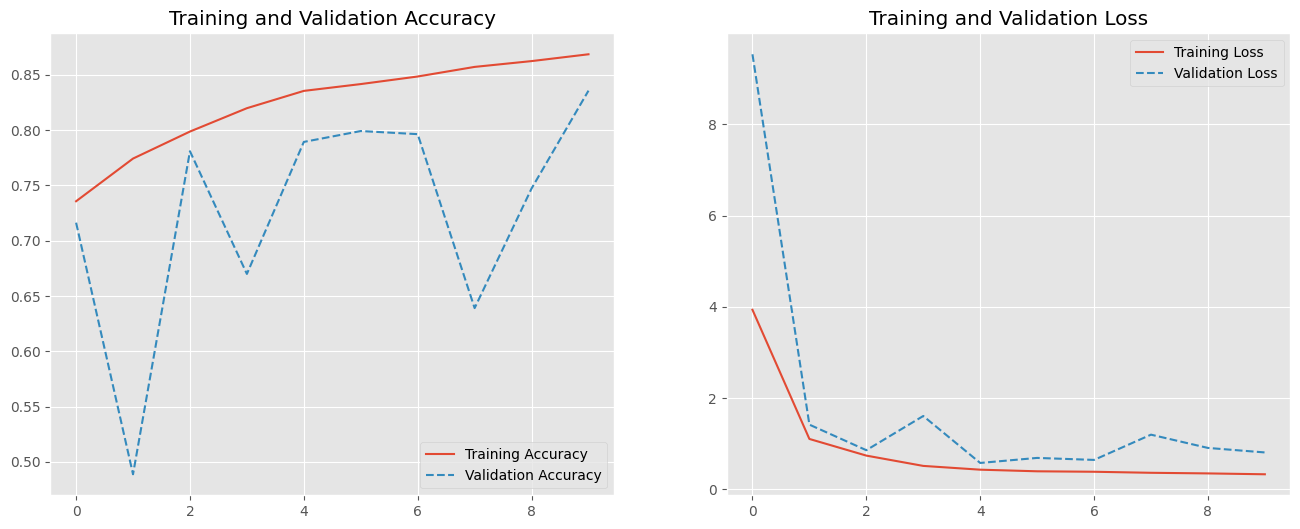

In [ ]:
#Plotting the model results
plot_result(history)

In [ ]:
pred = model.evaluate(test_gen)

7/7 [==============================] - 59s 8s/step - loss: 0.6346 - accuracy: 0.8331


In [ ]:
#load model
#model = tf.keras.models.load_model('./CNN6_model.h5')

Evaluate model with test set:
1/1 [==============================] - 2s 2s/step
Accuracy:  0.8331226295828066
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       242
           1       0.91      0.84      0.87       549

    accuracy                           0.83       791
   macro avg       0.80      0.83      0.81       791
weighted avg       0.85      0.83      0.84       791



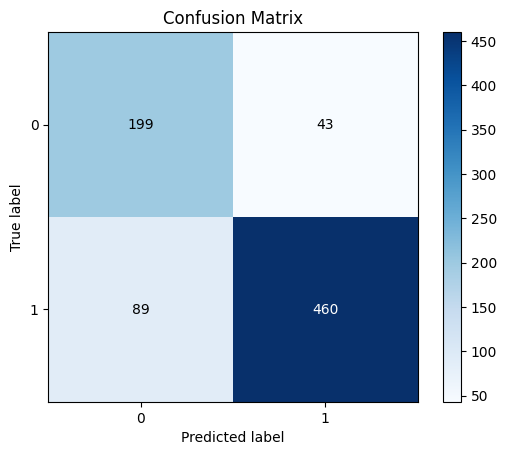

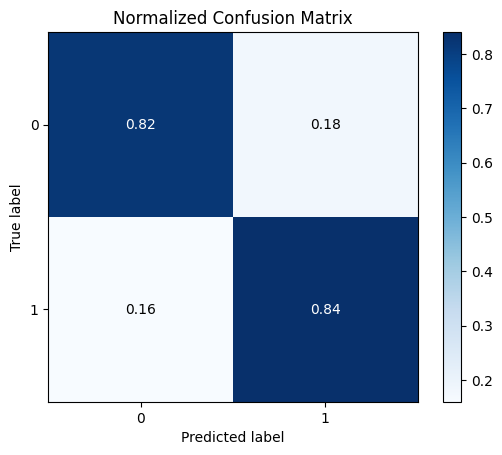

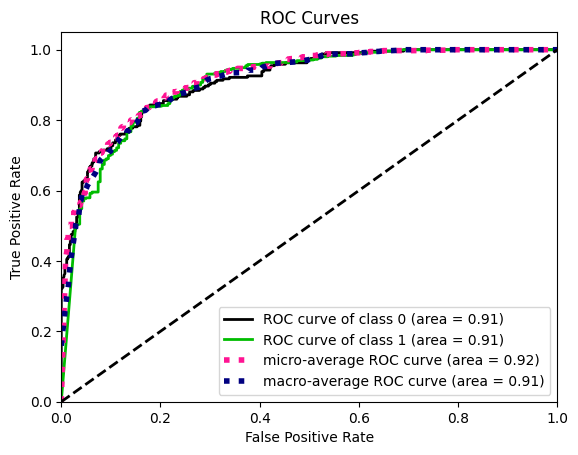

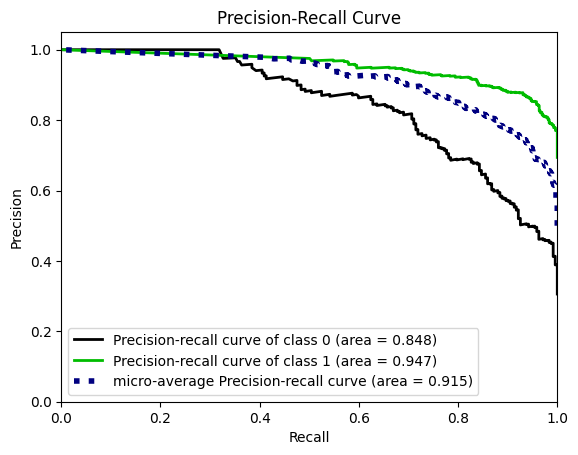

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen,model)

## MSB

#### 40x

In [ ]:
train_generation = dataset("./msb/40/training_image/",train = True)
val_generation = dataset("./msb/40/validating_image/",train = False)
test_gen = dataset("./msb/40/testing_image/",train = False)

Found 2158 files belonging to 2 classes.
Found 192 files belonging to 2 classes.
Found 204 files belonging to 2 classes.


In [ ]:
#build the model
model = model_builder()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 222, 222, 32)      9216      
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 111, 111, 64)     

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=8)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 10.2298 - accuracy: 0.6872 

17/17 [==============================] - 764s 27s/step - loss: 10.2298 - accuracy: 0.6872 - val_loss: 1103.1249 - val_accuracy: 0.6979
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 3.4632 - accuracy: 0.7206

17/17 [==============================] - 87s 4s/step - loss: 3.4632 - accuracy: 0.7206 - val_loss: 15.6684 - val_accuracy: 0.4792
Epoch 3/50
17/17 [==============================] - 83s 3s/step - loss: 2.0224 - accuracy: 0.7507 - val_loss: 32.9903 - val_accuracy: 0.6979
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 1.1792 - accuracy: 0.7623

17/17 [==============================] - 76s 4s/step - loss: 1.1792 - accuracy: 0.7623 - val_loss: 12.9303 - val_accuracy: 0.6875
Epoch 5/50
17/17 [==============================] - ETA: 0s - loss: 1.0625 - accuracy: 0.7799

17/17 [==============================] - 102s 5s/step - loss: 1.0625 - accuracy: 0.7799 - val_loss: 2.8328 - val_accuracy: 0.6979
Epoch 6/50
17/17 [==============================] - ETA: 0s - loss: 0.9312 - accuracy: 0.7882

17/17 [==============================] - 105s 5s/step - loss: 0.9312 - accuracy: 0.7882 - val_loss: 2.6825 - val_accuracy: 0.4688
Epoch 7/50
17/17 [==============================] - 87s 4s/step - loss: 0.5562 - accuracy: 0.8054 - val_loss: 4.2331 - val_accuracy: 0.3438
Epoch 8/50
17/17 [==============================] - 71s 3s/step - loss: 0.5215 - accuracy: 0.8017 - val_loss: 4.3385 - val_accuracy: 0.5938
Epoch 9/50
17/17 [==============================] - 72s 3s/step - loss: 0.4855 - accuracy: 0.8012 - val_loss: 5.1057 - val_accuracy: 0.3385
Epoch 10/50
17/17 [==============================] - 71s 3s/step - loss: 0.5241 - accuracy: 0.7938 - val_loss: 3.6128 - val_accuracy: 0.4479
Epoch 11/50
17/17 [==============================] - 71s 3s/step - loss: 0.5562 - accuracy: 0.7966 - val_loss: 19.4551 - val_accuracy: 0.7135
Epoch 12/50
17/17 [==============================] - 71s 3s/step - loss: 0.4470 - accuracy: 0.8295 - val_loss: 2.8919 - val_accuracy: 0.6510
Epoch 13/50
17/17 [=======

17/17 [==============================] - 79s 4s/step - loss: 0.3961 - accuracy: 0.8281 - val_loss: 0.9667 - val_accuracy: 0.6562
Epoch 14/50
17/17 [==============================] - 90s 4s/step - loss: 0.4139 - accuracy: 0.8267 - val_loss: 3.0853 - val_accuracy: 0.7344
Epoch 15/50
17/17 [==============================] - 75s 3s/step - loss: 0.4267 - accuracy: 0.8184 - val_loss: 2.2255 - val_accuracy: 0.7500
Epoch 16/50
17/17 [==============================] - 71s 3s/step - loss: 0.3660 - accuracy: 0.8387 - val_loss: 1.7883 - val_accuracy: 0.6146
Epoch 17/50
17/17 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8383

17/17 [==============================] - 86s 4s/step - loss: 0.3852 - accuracy: 0.8383 - val_loss: 0.4617 - val_accuracy: 0.7344
Epoch 18/50
17/17 [==============================] - 83s 3s/step - loss: 0.3795 - accuracy: 0.8304 - val_loss: 0.6924 - val_accuracy: 0.7917
Epoch 19/50
17/17 [==============================] - 74s 3s/step - loss: 0.3466 - accuracy: 0.8587 - val_loss: 0.9694 - val_accuracy: 0.6198
Epoch 20/50
17/17 [==============================] - 74s 3s/step - loss: 0.3376 - accuracy: 0.8545 - val_loss: 0.5712 - val_accuracy: 0.7344
Epoch 21/50
17/17 [==============================] - 71s 3s/step - loss: 0.3371 - accuracy: 0.8563 - val_loss: 0.4746 - val_accuracy: 0.8177
Epoch 22/50
17/17 [==============================] - 72s 3s/step - loss: 0.3143 - accuracy: 0.8670 - val_loss: 0.5605 - val_accuracy: 0.7500
Epoch 23/50
17/17 [==============================] - 73s 3s/step - loss: 0.3072 - accuracy: 0.8721 - val_loss: 0.6034 - val_accuracy: 0.7865
Epoch 24/50
17/17 [======

17/17 [==============================] - 95s 5s/step - loss: 0.3180 - accuracy: 0.8642 - val_loss: 0.4532 - val_accuracy: 0.8333
Epoch 25/50
17/17 [==============================] - 95s 3s/step - loss: 0.3050 - accuracy: 0.8675 - val_loss: 0.6498 - val_accuracy: 0.8021
Epoch 26/50
17/17 [==============================] - 75s 3s/step - loss: 0.3038 - accuracy: 0.8665 - val_loss: 0.6441 - val_accuracy: 0.7448
Epoch 27/50
17/17 [==============================] - 73s 3s/step - loss: 0.2968 - accuracy: 0.8767 - val_loss: 0.5590 - val_accuracy: 0.7812
Epoch 28/50
17/17 [==============================] - 72s 3s/step - loss: 0.2893 - accuracy: 0.8753 - val_loss: 0.7864 - val_accuracy: 0.6823
Epoch 29/50
17/17 [==============================] - 73s 3s/step - loss: 0.2794 - accuracy: 0.8814 - val_loss: 0.5962 - val_accuracy: 0.7448
Epoch 30/50
17/17 [==============================] - 73s 3s/step - loss: 0.2886 - accuracy: 0.8758 - val_loss: 0.6180 - val_accuracy: 0.7292
Epoch 31/50
17/17 [======

In [ ]:
model.save('CNN6_40_model.h5')

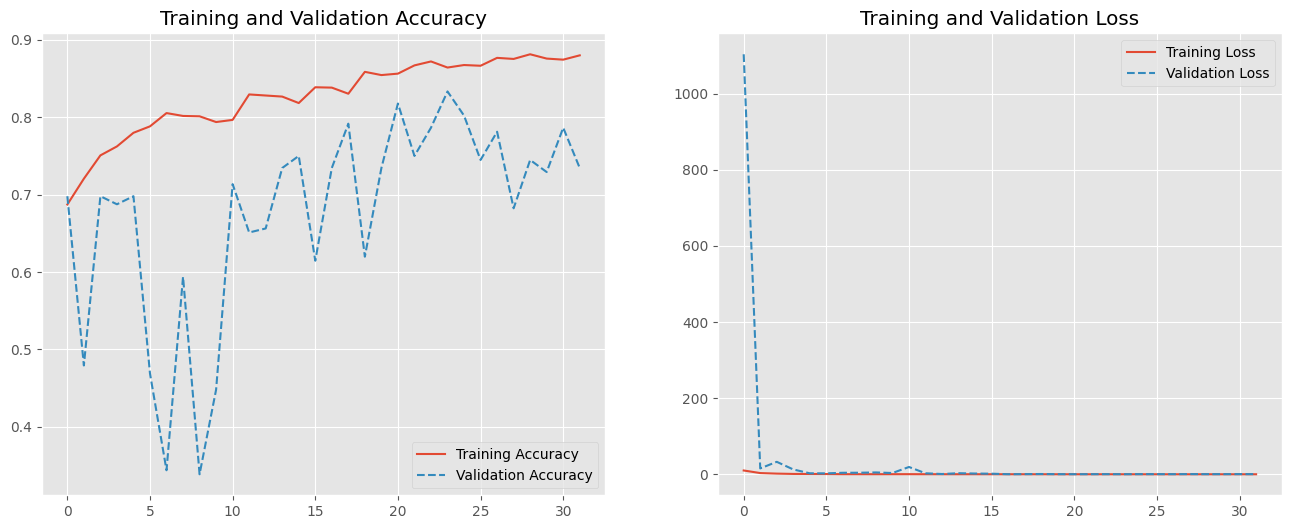

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./CNN6_40_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 3s 644ms/step - loss: 0.7598 - accuracy: 0.7010


Evaluate model with test set:


3/3 [==============================] - 0s 38ms/step
Accuracy:  0.7009803921568627
              precision    recall  f1-score   support

           0       0.48      0.72      0.58        58
           1       0.86      0.69      0.77       146

    accuracy                           0.70       204
   macro avg       0.67      0.71      0.67       204
weighted avg       0.76      0.70      0.71       204



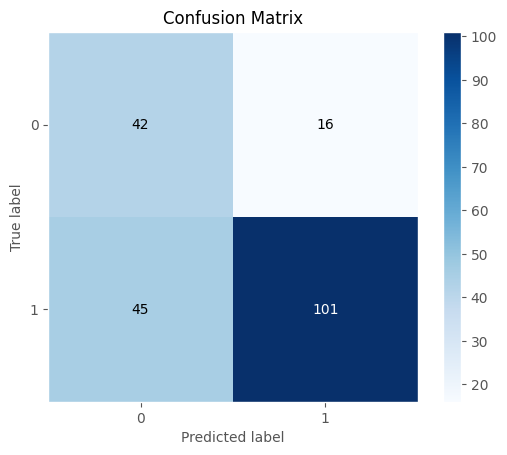

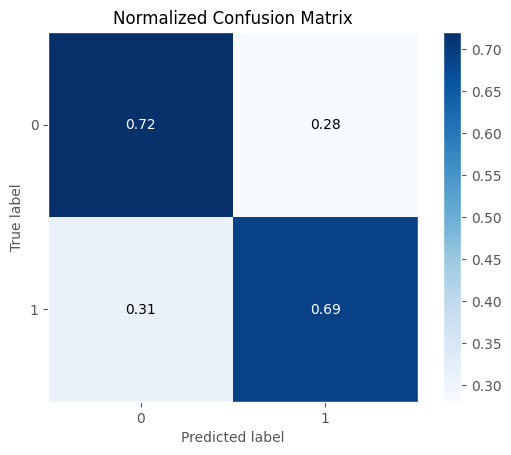

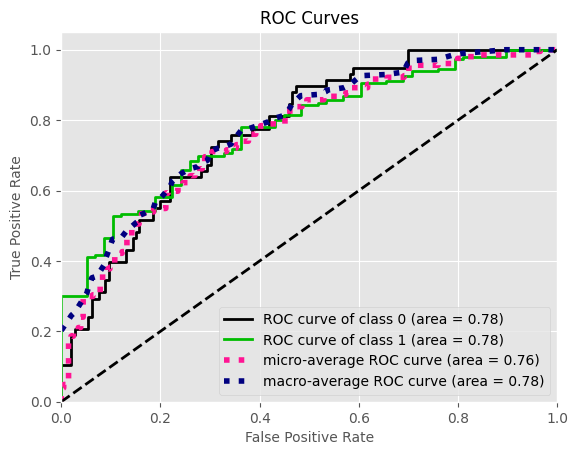

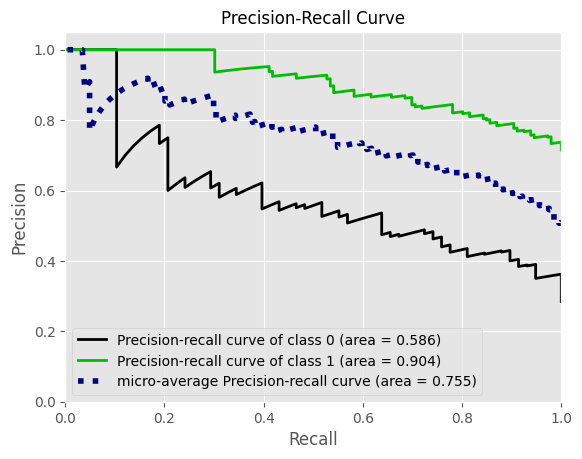

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

Evaluate model with test set:
3/3 [==============================] - 0s 131ms/step
Accuracy:  0.8029115341545353
              precision    recall  f1-score   support

           0       0.63      0.83      0.72       542
           1       0.92      0.79      0.85      1244

    accuracy                           0.80      1786
   macro avg       0.77      0.81      0.78      1786
weighted avg       0.83      0.80      0.81      1786



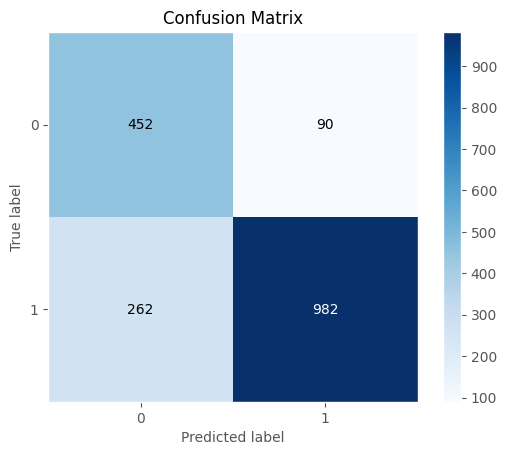

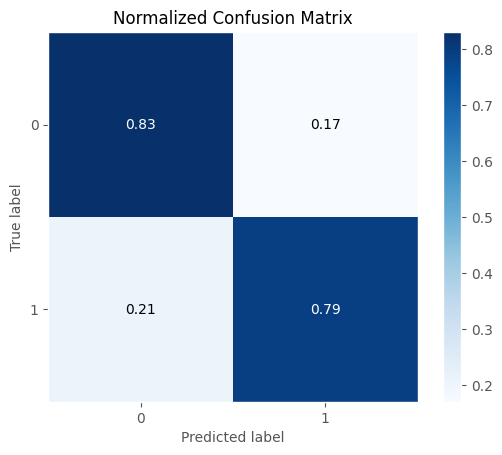

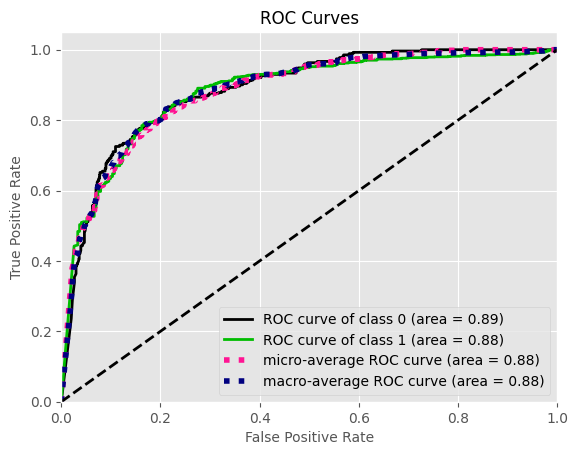

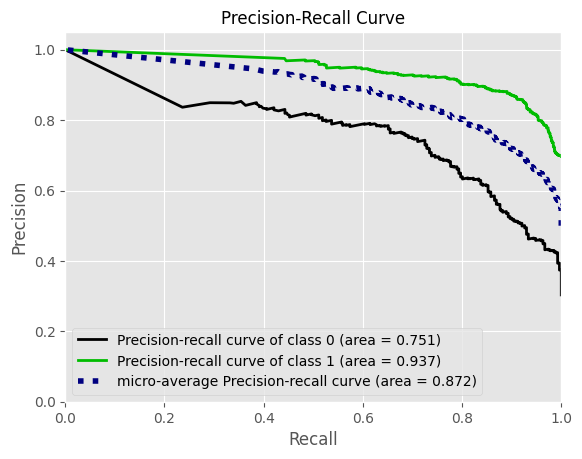

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 100X

In [ ]:
train_generation = dataset("./msb/100/training_image/",train = True)
val_generation = dataset("./msb/100/validating_image/",train = False)
test_gen = dataset("./msb/100/testing_image/",train = False)

Found 2389 files belonging to 2 classes.
Found 175 files belonging to 2 classes.
Found 190 files belonging to 2 classes.


In [ ]:
#build the model
model = model_builder()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 222, 222, 32)      9216      
                                                                 
 batch_normalization_6 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 111, 111, 64)     

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 11.6051 - accuracy: 0.6785

19/19 [==============================] - 149s 4s/step - loss: 11.6051 - accuracy: 0.6785 - val_loss: 85.4441 - val_accuracy: 0.7257
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 3.7076 - accuracy: 0.7363

19/19 [==============================] - 23s 883ms/step - loss: 3.7076 - accuracy: 0.7363 - val_loss: 21.5313 - val_accuracy: 0.7257
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.8787 - accuracy: 0.7518

19/19 [==============================] - 24s 918ms/step - loss: 1.8787 - accuracy: 0.7518 - val_loss: 13.2722 - val_accuracy: 0.7143
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 1.9994 - accuracy: 0.7137

19/19 [==============================] - 24s 929ms/step - loss: 1.9994 - accuracy: 0.7137 - val_loss: 8.3700 - val_accuracy: 0.6743
Epoch 5/50
19/19 [==============================] - ETA: 0s - loss: 0.8782 - accuracy: 0.7668

19/19 [==============================] - 22s 802ms/step - loss: 0.8782 - accuracy: 0.7668 - val_loss: 2.6252 - val_accuracy: 0.6114
Epoch 6/50
19/19 [==============================] - 18s 633ms/step - loss: 0.7455 - accuracy: 0.7555 - val_loss: 16.1668 - val_accuracy: 0.2914
Epoch 7/50
19/19 [==============================] - 19s 657ms/step - loss: 1.1196 - accuracy: 0.7409 - val_loss: 48.4409 - val_accuracy: 0.2514
Epoch 8/50
19/19 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.7434

19/19 [==============================] - 24s 885ms/step - loss: 0.9009 - accuracy: 0.7434 - val_loss: 2.2068 - val_accuracy: 0.5371
Epoch 9/50
19/19 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.7890

19/19 [==============================] - 22s 823ms/step - loss: 0.5272 - accuracy: 0.7890 - val_loss: 0.7889 - val_accuracy: 0.7543
Epoch 10/50
19/19 [==============================] - 18s 622ms/step - loss: 0.5584 - accuracy: 0.7798 - val_loss: 3.2169 - val_accuracy: 0.4971
Epoch 11/50
19/19 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.7756

19/19 [==============================] - 21s 789ms/step - loss: 0.6716 - accuracy: 0.7756 - val_loss: 0.7019 - val_accuracy: 0.7486
Epoch 12/50
19/19 [==============================] - ETA: 0s - loss: 0.5285 - accuracy: 0.7899

19/19 [==============================] - 24s 959ms/step - loss: 0.5285 - accuracy: 0.7899 - val_loss: 0.5521 - val_accuracy: 0.7943
Epoch 13/50
19/19 [==============================] - 18s 620ms/step - loss: 0.5846 - accuracy: 0.7878 - val_loss: 0.6424 - val_accuracy: 0.7029
Epoch 14/50
19/19 [==============================] - 18s 620ms/step - loss: 0.6076 - accuracy: 0.7735 - val_loss: 0.8122 - val_accuracy: 0.6629
Epoch 15/50
19/19 [==============================] - 18s 612ms/step - loss: 0.6206 - accuracy: 0.7698 - val_loss: 0.5833 - val_accuracy: 0.7486
Epoch 16/50
19/19 [==============================] - 18s 601ms/step - loss: 0.4557 - accuracy: 0.8028 - val_loss: 0.6613 - val_accuracy: 0.8229
Epoch 17/50
19/19 [==============================] - 18s 595ms/step - loss: 0.5207 - accuracy: 0.8049 - val_loss: 0.6152 - val_accuracy: 0.7257


In [ ]:
model.save('CNN6_100_model.h5')

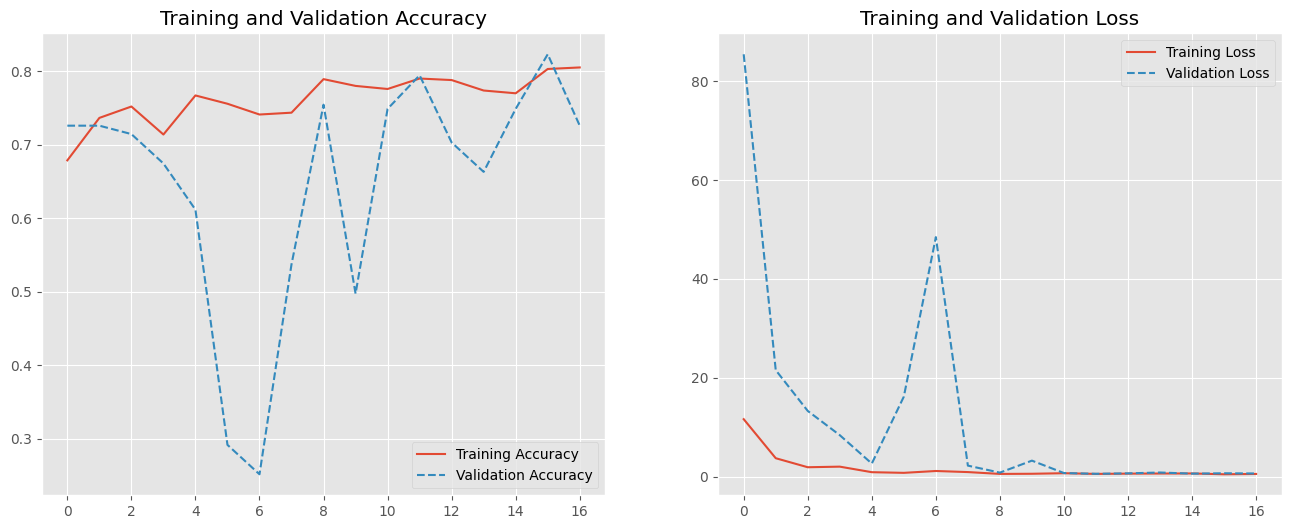

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./CNN6_100_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 42s 4s/step - loss: 0.6124 - accuracy: 0.7368


Evaluate model with test set:
2/2 [==============================] - 2s 2s/step
Accuracy:  0.7368421052631579
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        55
           1       0.73      1.00      0.84       135

    accuracy                           0.74       190
   macro avg       0.86      0.55      0.51       190
weighted avg       0.81      0.74      0.65       190



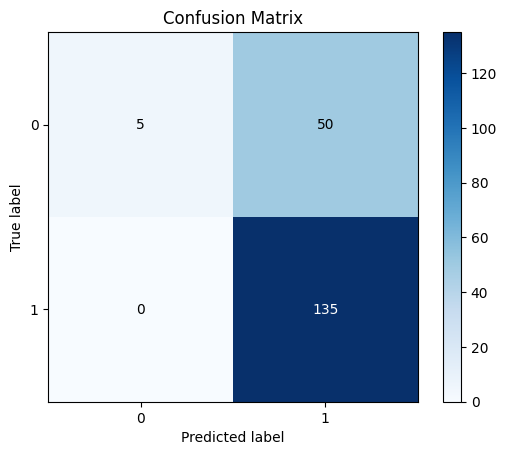

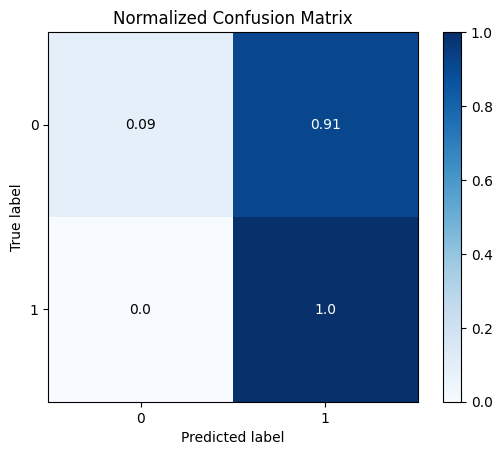

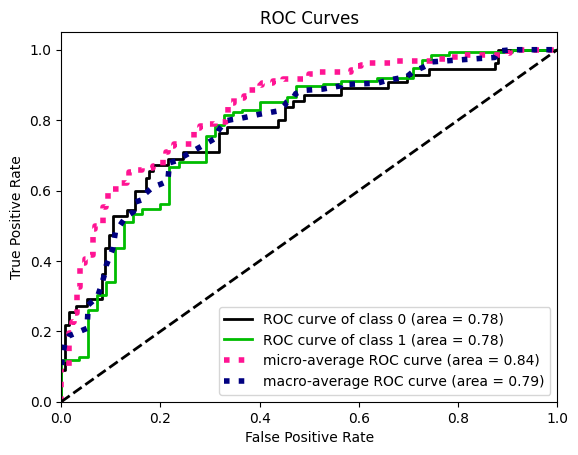

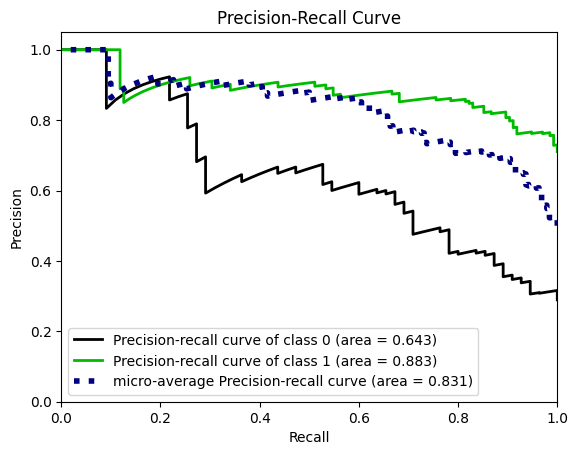

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 200X

In [ ]:
train_generation = dataset("./msb/200/training_image/",train = True)
val_generation = dataset("./msb/200/validating_image/",train = False)
test_gen = dataset("./msb/200/testing_image/",train = False)

Found 2215 files belonging to 2 classes.
Found 191 files belonging to 2 classes.
Found 211 files belonging to 2 classes.


In [ ]:
#build the model
model = model_builder()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9216      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      1

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 7.3381 - accuracy: 0.7639 

18/18 [==============================] - 680s 21s/step - loss: 7.3381 - accuracy: 0.7639 - val_loss: 303.3123 - val_accuracy: 0.6963
Epoch 2/50
18/18 [==============================] - 76s 3s/step - loss: 2.5059 - accuracy: 0.8131 - val_loss: 601.4705 - val_accuracy: 0.2932
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.7533 - accuracy: 0.7810

18/18 [==============================] - 85s 4s/step - loss: 1.7533 - accuracy: 0.7810 - val_loss: 104.5219 - val_accuracy: 0.2932
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.8913 - accuracy: 0.8005

18/18 [==============================] - 77s 3s/step - loss: 0.8913 - accuracy: 0.8005 - val_loss: 17.2574 - val_accuracy: 0.3717
Epoch 5/50
18/18 [==============================] - ETA: 0s - loss: 0.8495 - accuracy: 0.8230

18/18 [==============================] - 78s 4s/step - loss: 0.8495 - accuracy: 0.8230 - val_loss: 5.5373 - val_accuracy: 0.5654
Epoch 6/50
18/18 [==============================] - 75s 3s/step - loss: 0.6402 - accuracy: 0.8208 - val_loss: 8.7019 - val_accuracy: 0.2932
Epoch 7/50
18/18 [==============================] - 71s 3s/step - loss: 0.5486 - accuracy: 0.8230 - val_loss: 47.7526 - val_accuracy: 0.2880
Epoch 8/50
18/18 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.8312

18/18 [==============================] - 76s 4s/step - loss: 0.5064 - accuracy: 0.8312 - val_loss: 2.1422 - val_accuracy: 0.2984
Epoch 9/50
18/18 [==============================] - 70s 3s/step - loss: 0.4037 - accuracy: 0.8393 - val_loss: 3.0236 - val_accuracy: 0.2932
Epoch 10/50
18/18 [==============================] - ETA: 0s - loss: 0.4100 - accuracy: 0.8280

18/18 [==============================] - 81s 4s/step - loss: 0.4100 - accuracy: 0.8280 - val_loss: 2.1262 - val_accuracy: 0.3089
Epoch 11/50
18/18 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8248

18/18 [==============================] - 77s 3s/step - loss: 0.3658 - accuracy: 0.8248 - val_loss: 1.5315 - val_accuracy: 0.3194
Epoch 12/50
18/18 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8366

18/18 [==============================] - 83s 4s/step - loss: 0.3565 - accuracy: 0.8366 - val_loss: 0.9316 - val_accuracy: 0.3194
Epoch 13/50
18/18 [==============================] - 73s 3s/step - loss: 0.3502 - accuracy: 0.8411 - val_loss: 1.1030 - val_accuracy: 0.3351
Epoch 14/50
18/18 [==============================] - 72s 3s/step - loss: 0.3228 - accuracy: 0.8546 - val_loss: 0.9714 - val_accuracy: 0.3613
Epoch 15/50
18/18 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.8442

18/18 [==============================] - 77s 4s/step - loss: 0.3378 - accuracy: 0.8442 - val_loss: 0.5544 - val_accuracy: 0.6806
Epoch 16/50
18/18 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8474

18/18 [==============================] - 95s 4s/step - loss: 0.3264 - accuracy: 0.8474 - val_loss: 0.5109 - val_accuracy: 0.8272
Epoch 17/50
18/18 [==============================] - 79s 3s/step - loss: 0.3852 - accuracy: 0.8402 - val_loss: 1.1204 - val_accuracy: 0.7749
Epoch 18/50
18/18 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8429

18/18 [==============================] - 75s 3s/step - loss: 0.3435 - accuracy: 0.8429 - val_loss: 0.3928 - val_accuracy: 0.7801
Epoch 19/50
18/18 [==============================] - 74s 3s/step - loss: 0.3371 - accuracy: 0.8411 - val_loss: 1.6566 - val_accuracy: 0.8063
Epoch 20/50
18/18 [==============================] - 72s 3s/step - loss: 0.3320 - accuracy: 0.8510 - val_loss: 2.8142 - val_accuracy: 0.7801
Epoch 21/50
18/18 [==============================] - 72s 3s/step - loss: 0.2857 - accuracy: 0.8619 - val_loss: 1.5992 - val_accuracy: 0.8534
Epoch 22/50
18/18 [==============================] - 67s 3s/step - loss: 0.2923 - accuracy: 0.8600 - val_loss: 1.7085 - val_accuracy: 0.8482
Epoch 23/50
18/18 [==============================] - 67s 3s/step - loss: 0.2849 - accuracy: 0.8573 - val_loss: 6.2640 - val_accuracy: 0.8272


In [ ]:
model.save('CNN6_200_model.h5')

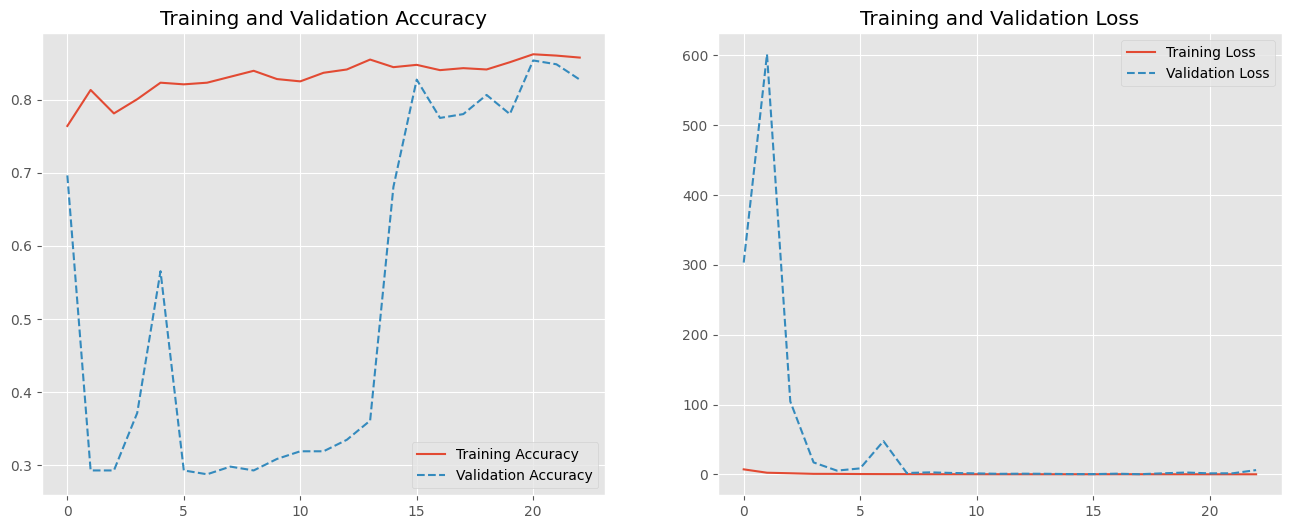

In [ ]:
plot_result(history)

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 90s 34s/step - loss: 4.7012 - accuracy: 0.8910


Evaluate model with test set:
3/3 [==============================] - 1s 619ms/step
Accuracy:  0.8909952606635071
              precision    recall  f1-score   support

           0       0.78      0.89      0.83        64
           1       0.95      0.89      0.92       147

    accuracy                           0.89       211
   macro avg       0.87      0.89      0.88       211
weighted avg       0.90      0.89      0.89       211



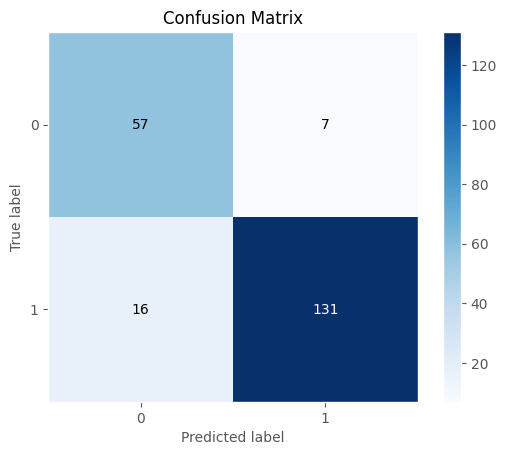

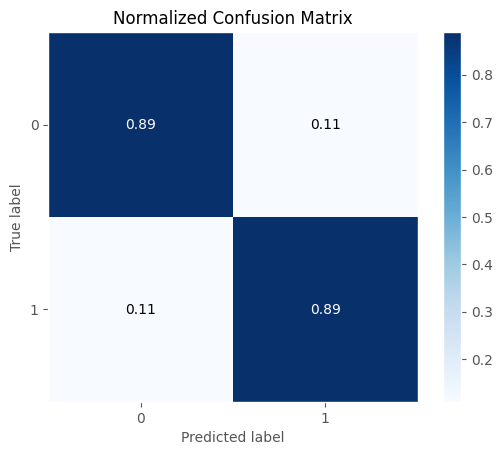

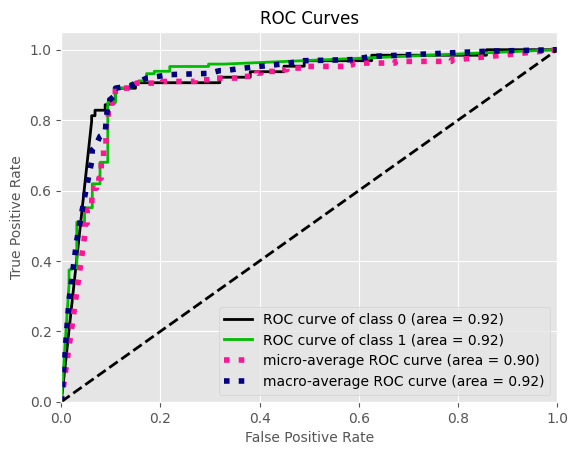

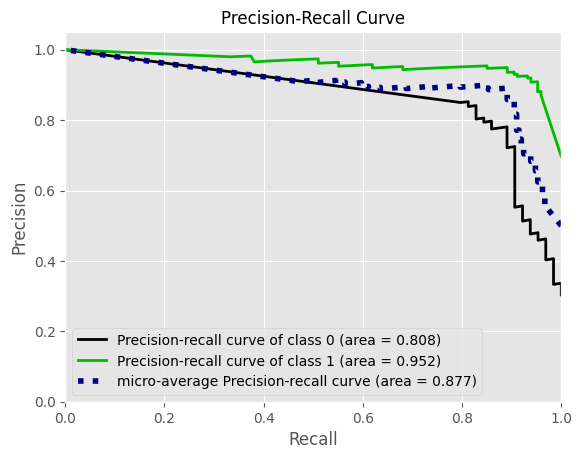

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 400X

In [ ]:
train_generation = dataset("./msb/400/training_image/",train = True)
val_generation = dataset("./msb/400/validating_image/",train = False)
test_gen = dataset("./msb/400/testing_image/",train = False)

Found 1996 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
Found 186 files belonging to 2 classes.


In [ ]:
#build the model
model = model_builder()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 222, 222, 32)      9216      
                                                                 
 batch_normalization_9 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 111, 111, 64)     

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=8)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 8.6009 - accuracy: 0.7004

16/16 [==============================] - 81s 3s/step - loss: 8.6009 - accuracy: 0.7004 - val_loss: 447.4496 - val_accuracy: 0.2857
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 1.4938 - accuracy: 0.7530

16/16 [==============================] - 72s 3s/step - loss: 1.4938 - accuracy: 0.7530 - val_loss: 7.5509 - val_accuracy: 0.7078
Epoch 3/50
16/16 [==============================] - 67s 3s/step - loss: 1.1263 - accuracy: 0.7605 - val_loss: 10.8738 - val_accuracy: 0.7143
Epoch 4/50
16/16 [==============================] - 66s 3s/step - loss: 0.9446 - accuracy: 0.7886 - val_loss: 8.0944 - val_accuracy: 0.7143
Epoch 5/50
16/16 [==============================] - 60s 3s/step - loss: 0.8114 - accuracy: 0.7846 - val_loss: 8.5240 - val_accuracy: 0.7143
Epoch 6/50
16/16 [==============================] - ETA: 0s - loss: 0.8204 - accuracy: 0.8141

16/16 [==============================] - 71s 4s/step - loss: 0.8204 - accuracy: 0.8141 - val_loss: 6.6849 - val_accuracy: 0.6429
Epoch 7/50
16/16 [==============================] - ETA: 0s - loss: 0.8082 - accuracy: 0.8126

16/16 [==============================] - 77s 3s/step - loss: 0.8082 - accuracy: 0.8126 - val_loss: 4.2221 - val_accuracy: 0.6558
Epoch 8/50
16/16 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.8246

16/16 [==============================] - 70s 4s/step - loss: 0.6385 - accuracy: 0.8246 - val_loss: 2.4981 - val_accuracy: 0.7208
Epoch 9/50
16/16 [==============================] - 63s 3s/step - loss: 0.8066 - accuracy: 0.8221 - val_loss: 3.6338 - val_accuracy: 0.6558
Epoch 10/50
16/16 [==============================] - 59s 3s/step - loss: 0.5777 - accuracy: 0.8241 - val_loss: 3.3629 - val_accuracy: 0.6234
Epoch 11/50
16/16 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.8372

16/16 [==============================] - 67s 3s/step - loss: 0.4540 - accuracy: 0.8372 - val_loss: 0.7830 - val_accuracy: 0.8312
Epoch 12/50
16/16 [==============================] - 63s 3s/step - loss: 0.5289 - accuracy: 0.8246 - val_loss: 1.2094 - val_accuracy: 0.8117
Epoch 13/50
16/16 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.8552

16/16 [==============================] - 74s 4s/step - loss: 0.4125 - accuracy: 0.8552 - val_loss: 0.7574 - val_accuracy: 0.6169
Epoch 14/50
16/16 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8557

16/16 [==============================] - 80s 4s/step - loss: 0.3940 - accuracy: 0.8557 - val_loss: 0.6327 - val_accuracy: 0.7662
Epoch 15/50
16/16 [==============================] - 64s 3s/step - loss: 0.3767 - accuracy: 0.8502 - val_loss: 0.7769 - val_accuracy: 0.5974
Epoch 16/50
16/16 [==============================] - ETA: 0s - loss: 0.3810 - accuracy: 0.8632

16/16 [==============================] - 72s 4s/step - loss: 0.3810 - accuracy: 0.8632 - val_loss: 0.4326 - val_accuracy: 0.7727
Epoch 17/50
16/16 [==============================] - 70s 3s/step - loss: 0.3683 - accuracy: 0.8617 - val_loss: 0.5098 - val_accuracy: 0.8052
Epoch 18/50
16/16 [==============================] - 63s 3s/step - loss: 0.3608 - accuracy: 0.8572 - val_loss: 1.2732 - val_accuracy: 0.5195
Epoch 19/50
16/16 [==============================] - 67s 3s/step - loss: 0.4871 - accuracy: 0.8392 - val_loss: 1.5533 - val_accuracy: 0.4740
Epoch 20/50
16/16 [==============================] - 60s 3s/step - loss: 0.3994 - accuracy: 0.8677 - val_loss: 0.8286 - val_accuracy: 0.6883
Epoch 21/50
16/16 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8712

16/16 [==============================] - 71s 4s/step - loss: 0.3374 - accuracy: 0.8712 - val_loss: 0.4155 - val_accuracy: 0.8896
Epoch 22/50
16/16 [==============================] - 71s 3s/step - loss: 0.3464 - accuracy: 0.8692 - val_loss: 0.5657 - val_accuracy: 0.8052
Epoch 23/50
16/16 [==============================] - 60s 3s/step - loss: 0.3584 - accuracy: 0.8727 - val_loss: 0.8676 - val_accuracy: 0.6494
Epoch 24/50
16/16 [==============================] - 60s 3s/step - loss: 0.3598 - accuracy: 0.8712 - val_loss: 1.3103 - val_accuracy: 0.5649
Epoch 25/50
16/16 [==============================] - 62s 3s/step - loss: 0.2828 - accuracy: 0.8993 - val_loss: 1.5220 - val_accuracy: 0.5390
Epoch 26/50
16/16 [==============================] - 59s 3s/step - loss: 0.2848 - accuracy: 0.8873 - val_loss: 0.8447 - val_accuracy: 0.6169
Epoch 27/50
16/16 [==============================] - 61s 3s/step - loss: 0.3067 - accuracy: 0.8908 - val_loss: 2.2736 - val_accuracy: 0.3896
Epoch 28/50
16/16 [======

In [ ]:
model.save('CNN6_400_model.h5')

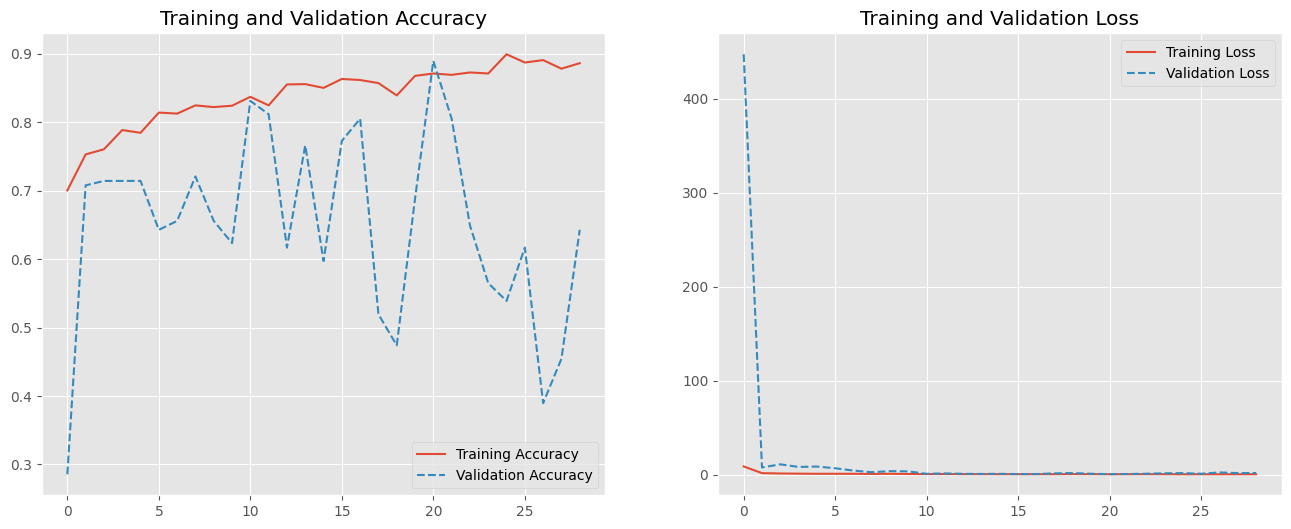

In [ ]:
plot_result(history)

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 4s 869ms/step - loss: 1.7421 - accuracy: 0.6237


Evaluate model with test set:
2/2 [==============================] - 0s 34ms/step
Accuracy:  0.6236559139784946
              precision    recall  f1-score   support

           0       0.48      0.98      0.65        65
           1       0.98      0.43      0.60       121

    accuracy                           0.62       186
   macro avg       0.73      0.71      0.62       186
weighted avg       0.81      0.62      0.61       186



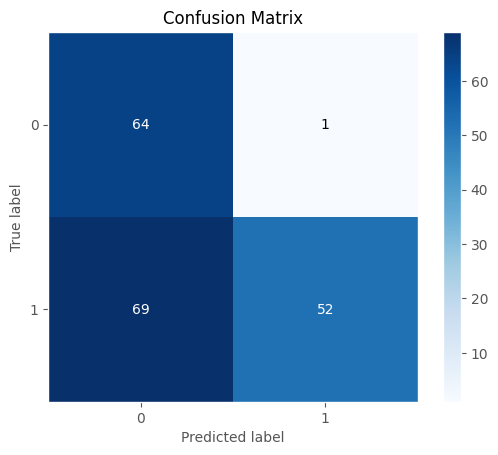

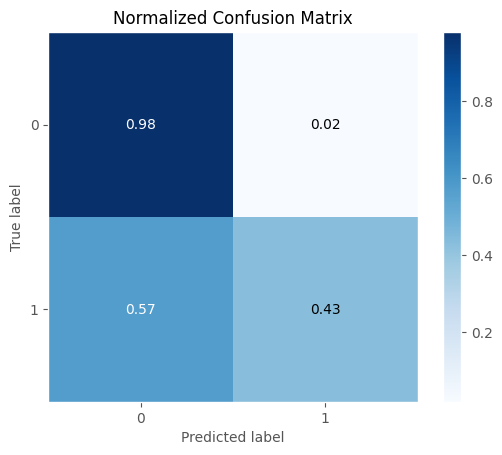

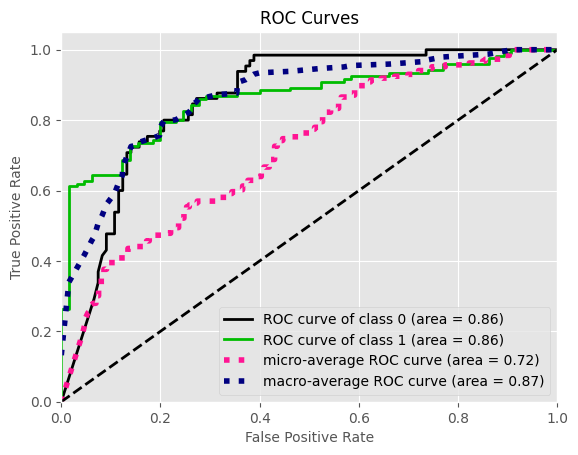

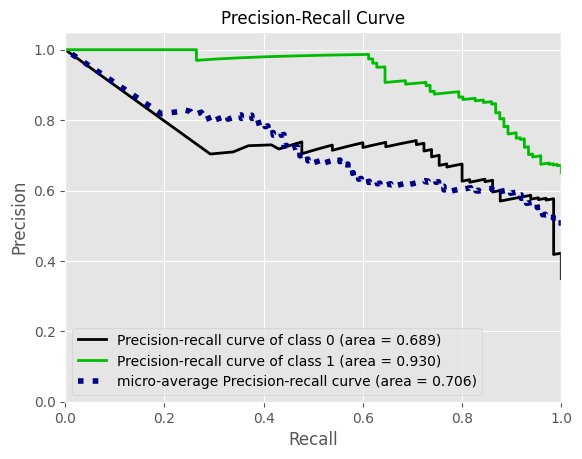

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

##MIM

In [ ]:
train_generation = dataset("./subclass/training_image/",train = True)
val_generation = dataset("./subclass/validating_image/",train = False)
test_gen = dataset("./subclass/testing_image/",train = False)

Found 8758 files belonging to 8 classes.
Found 712 files belonging to 8 classes.
Found 791 files belonging to 8 classes.


In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)

In [ ]:
def mmodel_builder():
    model = Sequential()

    # 1st conv => relu => pool
    model.add(Conv2D(filters = 32, kernel_size=(3,3), padding="same", input_shape= (224,224,3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size=(3,3), use_bias=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd conv => relu => pool
    model.add(Conv2D(filters = 64, kernel_size=(3,3), padding="same", activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size=(3,3), use_bias=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    # 3rd conv => relu => pool
    model.add(Conv2D(filters = 128, kernel_size=(5,5), padding="same", activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size=(5,5), use_bias=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    # flatten layer
    model.add(Flatten())

    # Dropout layer
    model.add(Dropout(0.4, name='Dropout'))
    model.add(BatchNormalization())

    # Dense layer
    model.add(Dense(512, activation="relu"))
   #model.add(Dense(128, activation="relu"))
    model.add(Dense(8, activation="softmax"))

    return model

In [ ]:
#Defining the base model
model = mmodel_builder()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9216      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      1

In [ ]:
#Compiling the model
model.compile(loss='CategoricalCrossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=6)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Model is fitted using train and validation generator for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 17.3313 - accuracy: 0.2968 

69/69 [==============================] - 1165s 15s/step - loss: 17.3313 - accuracy: 0.2968 - val_loss: 55.2449 - val_accuracy: 0.1236
Epoch 2/50
69/69 [==============================] - 264s 4s/step - loss: 8.6254 - accuracy: 0.3357 - val_loss: 634.0938 - val_accuracy: 0.4382
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 6.0976 - accuracy: 0.3276

69/69 [==============================] - 267s 4s/step - loss: 6.0976 - accuracy: 0.3276 - val_loss: 4.0188 - val_accuracy: 0.4424
Epoch 4/50
69/69 [==============================] - 263s 4s/step - loss: 3.5846 - accuracy: 0.3628 - val_loss: 21.4002 - val_accuracy: 0.4298
Epoch 5/50
69/69 [==============================] - 262s 4s/step - loss: 2.6893 - accuracy: 0.4057 - val_loss: 125.9924 - val_accuracy: 0.4382
Epoch 6/50
69/69 [==============================] - ETA: 0s - loss: 2.2491 - accuracy: 0.4523

69/69 [==============================] - 280s 4s/step - loss: 2.2491 - accuracy: 0.4523 - val_loss: 3.0258 - val_accuracy: 0.4382
Epoch 7/50
69/69 [==============================] - 278s 4s/step - loss: 1.8193 - accuracy: 0.4809 - val_loss: 60.3242 - val_accuracy: 0.2823
Epoch 8/50
69/69 [==============================] - ETA: 0s - loss: 1.4072 - accuracy: 0.5185

69/69 [==============================] - 271s 4s/step - loss: 1.4072 - accuracy: 0.5185 - val_loss: 1.7705 - val_accuracy: 0.5211
Epoch 9/50
69/69 [==============================] - 268s 4s/step - loss: 1.2129 - accuracy: 0.5661 - val_loss: 3.5186 - val_accuracy: 0.5365
Epoch 10/50
69/69 [==============================] - 266s 4s/step - loss: 1.1012 - accuracy: 0.6020 - val_loss: 10.1645 - val_accuracy: 0.3272
Epoch 11/50
69/69 [==============================] - ETA: 0s - loss: 1.0683 - accuracy: 0.6077

69/69 [==============================] - 273s 4s/step - loss: 1.0683 - accuracy: 0.6077 - val_loss: 1.7225 - val_accuracy: 0.5337
Epoch 12/50
69/69 [==============================] - 274s 4s/step - loss: 0.9935 - accuracy: 0.6302 - val_loss: 6.4900 - val_accuracy: 0.3961
Epoch 13/50
69/69 [==============================] - ETA: 0s - loss: 0.9810 - accuracy: 0.6436

69/69 [==============================] - 284s 4s/step - loss: 0.9810 - accuracy: 0.6436 - val_loss: 1.6739 - val_accuracy: 0.4888
Epoch 14/50
69/69 [==============================] - 279s 4s/step - loss: 0.9283 - accuracy: 0.6559 - val_loss: 16.2482 - val_accuracy: 0.2444
Epoch 15/50
69/69 [==============================] - 267s 4s/step - loss: 0.9057 - accuracy: 0.6683 - val_loss: 8.7739 - val_accuracy: 0.3244
Epoch 16/50
69/69 [==============================] - 270s 4s/step - loss: 0.8958 - accuracy: 0.6654 - val_loss: 2.7974 - val_accuracy: 0.3581
Epoch 17/50
69/69 [==============================] - 271s 4s/step - loss: 0.8745 - accuracy: 0.6819 - val_loss: 2.2374 - val_accuracy: 0.3989
Epoch 18/50
69/69 [==============================] - 267s 4s/step - loss: 0.8402 - accuracy: 0.6939 - val_loss: 1.9064 - val_accuracy: 0.4270
Epoch 19/50
69/69 [==============================] - 266s 4s/step - loss: 0.7856 - accuracy: 0.7044 - val_loss: 2.0057 - val_accuracy: 0.4803


In [ ]:
model.save('CNN6_Mmodel.h5')

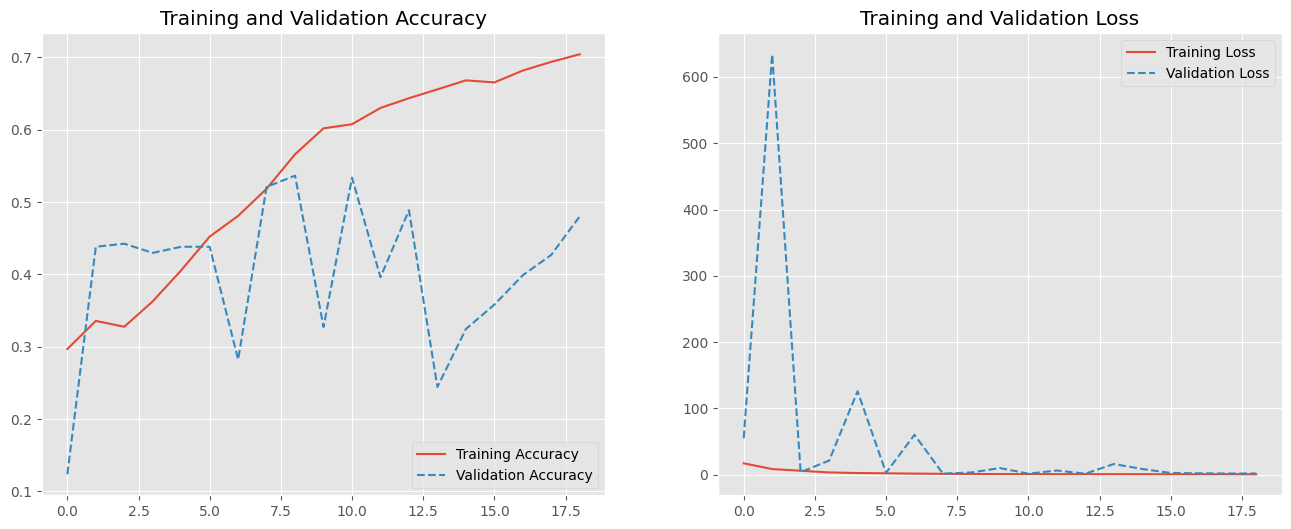

In [ ]:
plot_result(history)

In [ ]:
pred = model.evaluate(test_gen)

7/7 [==============================] - 103s 14s/step - loss: 1.8773 - accuracy: 0.5032


Evaluate model with test set:
1/1 [==============================] - 0s 151ms/step
Accuracy:  0.5031605562579013
              precision    recall  f1-score   support

           0       0.40      0.73      0.52        45
           1       0.85      0.56      0.67       339
           2       0.46      0.64      0.53        95
           3       0.53      0.12      0.20        66
           4       0.57      0.18      0.28        88
           5       0.27      0.52      0.35        56
           6       0.27      0.55      0.36        49
           7       0.35      0.64      0.45        53

    accuracy                           0.50       791
   macro avg       0.46      0.49      0.42       791
weighted avg       0.61      0.50      0.51       791



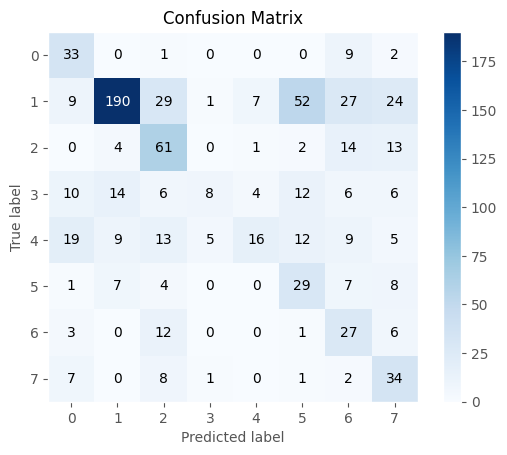

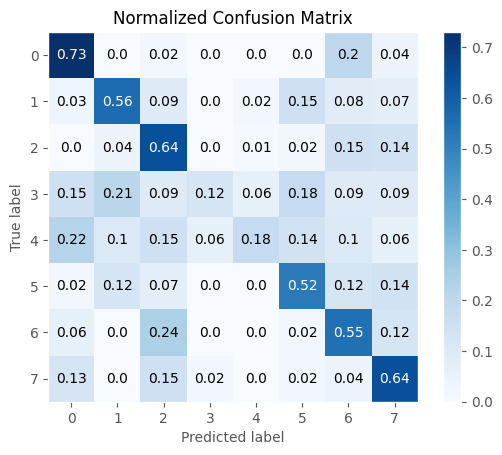

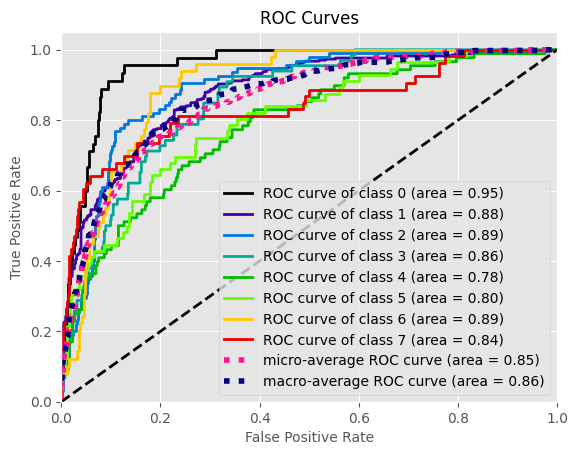

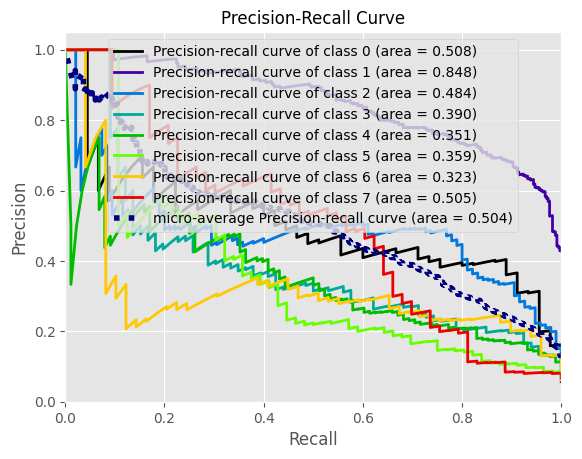

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model)

### MIM mag test

In [ ]:
model = tf.keras.models.load_model("./CNN6_Mmodel.h5")

####40x

In [ ]:
test_gen = dataset("./mag_test/40/",train = False)

Found 204 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 35s 4s/step - loss: 2.0434 - accuracy: 0.4461


Evaluate model with test set:
3/3 [==============================] - 1s 405ms/step
Accuracy:  0.44607843137254904
              precision    recall  f1-score   support

           0       0.47      0.80      0.59        10
           1       0.84      0.45      0.59        82
           2       0.33      0.73      0.46        22
           3       0.50      0.11      0.17        19
           4       0.62      0.21      0.31        24
           5       0.28      0.62      0.38        21
           6       0.25      0.31      0.28        16
           7       0.31      0.50      0.38        10

    accuracy                           0.45       204
   macro avg       0.45      0.47      0.40       204
weighted avg       0.58      0.45      0.45       204



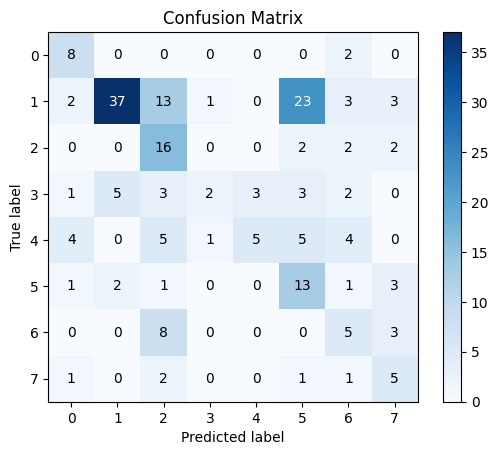

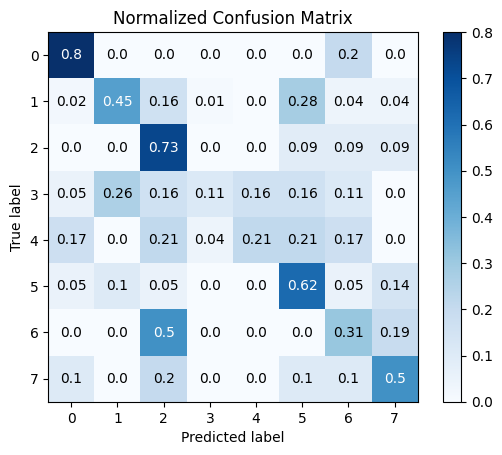

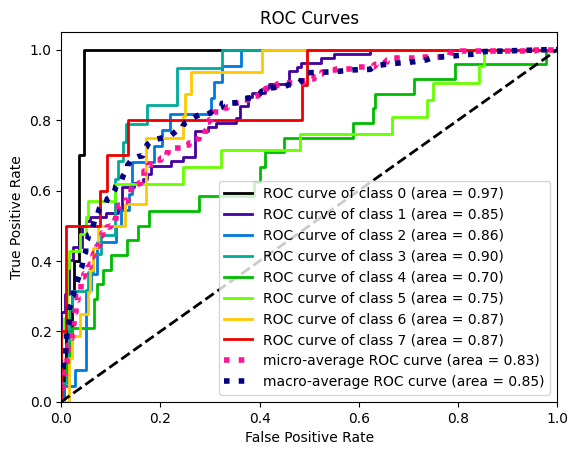

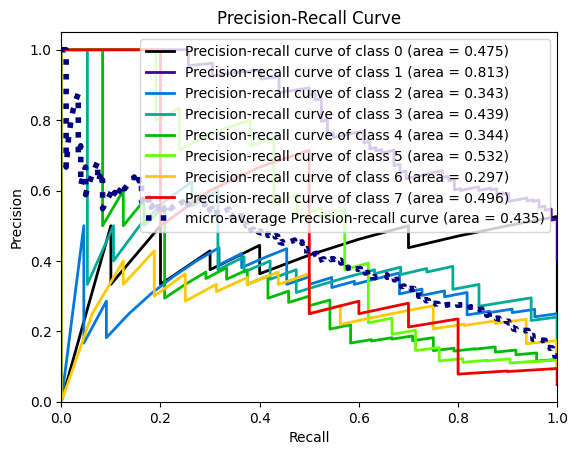

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####100x

In [ ]:
test_gen = dataset("./mag_test/100/",train = False)

Found 190 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 20s 8s/step - loss: 2.0842 - accuracy: 0.4789


Evaluate model with test set:
2/2 [==============================] - 2s 2s/step
Accuracy:  0.4789473684210526
              precision    recall  f1-score   support

           0       0.29      0.56      0.38         9
           1       0.85      0.51      0.63        89
           2       0.53      0.68      0.60        25
           3       0.75      0.21      0.33        14
           4       0.40      0.08      0.14        24
           5       0.32      0.75      0.44         8
           6       0.18      0.38      0.24         8
           7       0.23      0.77      0.36        13

    accuracy                           0.48       190
   macro avg       0.44      0.49      0.39       190
weighted avg       0.62      0.48      0.49       190



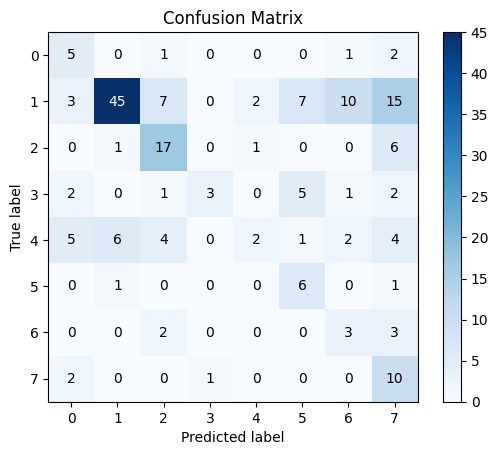

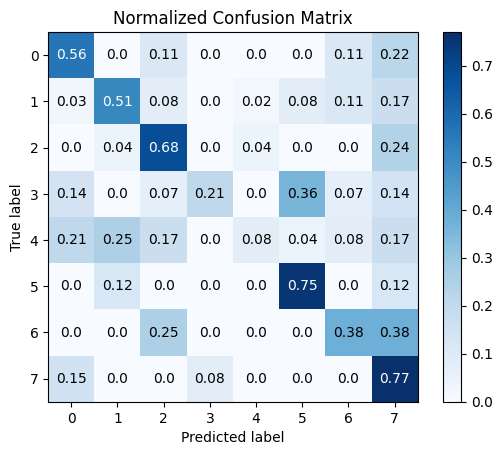

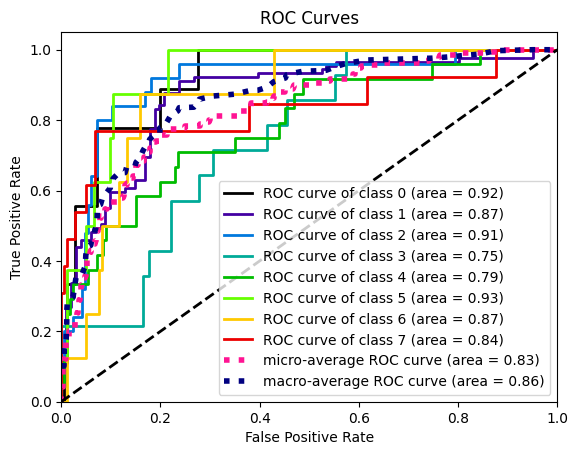

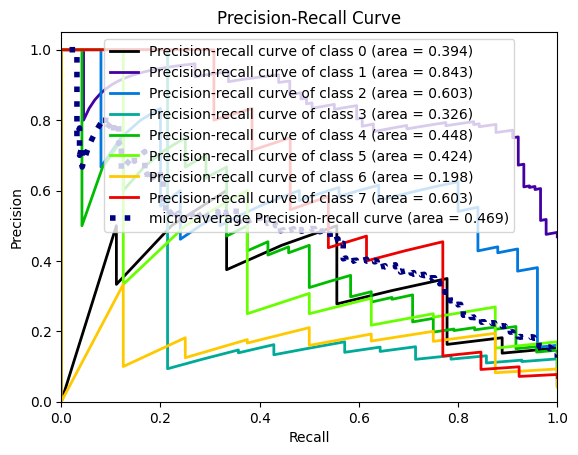

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####200x

In [ ]:
test_gen = dataset("./mag_test/200/",train = False)

Found 211 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 23s 12s/step - loss: 1.7118 - accuracy: 0.5545


Evaluate model with test set:
3/3 [==============================] - 1s 597ms/step
Accuracy:  0.5545023696682464
              precision    recall  f1-score   support

           0       0.43      0.77      0.56        13
           1       0.88      0.66      0.76        92
           2       0.57      0.59      0.58        29
           3       0.43      0.14      0.21        21
           4       0.50      0.19      0.28        21
           5       0.19      0.38      0.26        13
           6       0.26      0.80      0.39        10
           7       0.53      0.75      0.62        12

    accuracy                           0.55       211
   macro avg       0.47      0.54      0.46       211
weighted avg       0.64      0.55      0.56       211



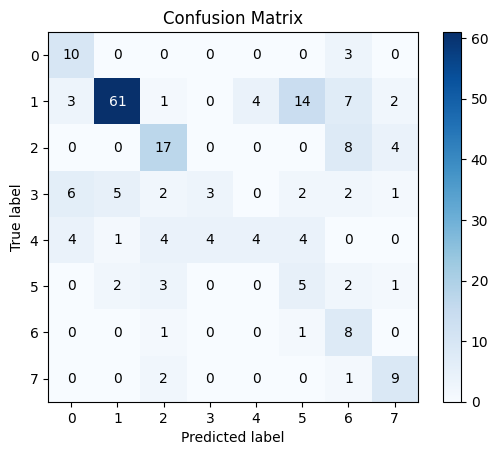

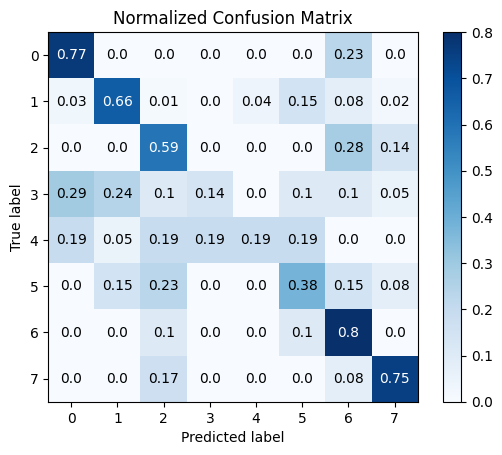

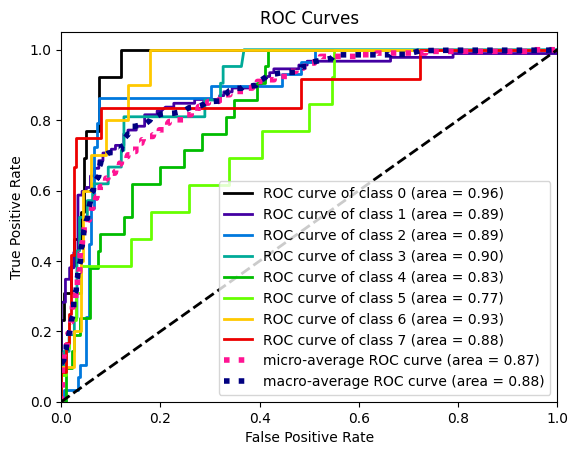

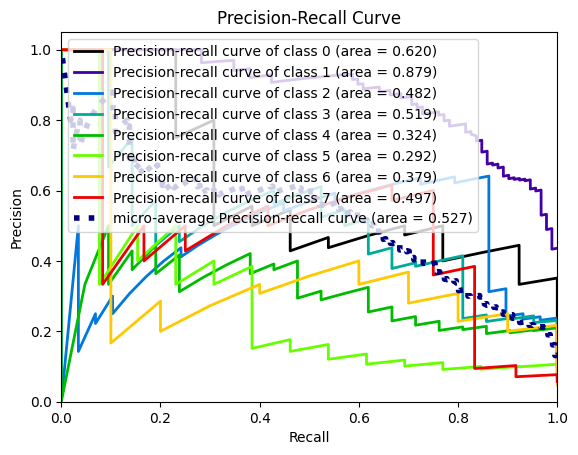

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####400x

In [ ]:
test_gen = dataset("./mag_test/400/",train = False)

Found 186 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 20s 8s/step - loss: 1.6716 - accuracy: 0.5323


Evaluate model with test set:
2/2 [==============================] - 2s 2s/step
Accuracy:  0.532258064516129
              precision    recall  f1-score   support

           0       0.40      0.77      0.53        13
           1       0.81      0.62      0.70        76
           2       0.46      0.58      0.51        19
           3       0.00      0.00      0.00        12
           4       0.71      0.26      0.38        19
           5       0.29      0.36      0.32        14
           6       0.33      0.73      0.46        15
           7       0.45      0.56      0.50        18

    accuracy                           0.53       186
   macro avg       0.43      0.48      0.43       186
weighted avg       0.57      0.53      0.52       186



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


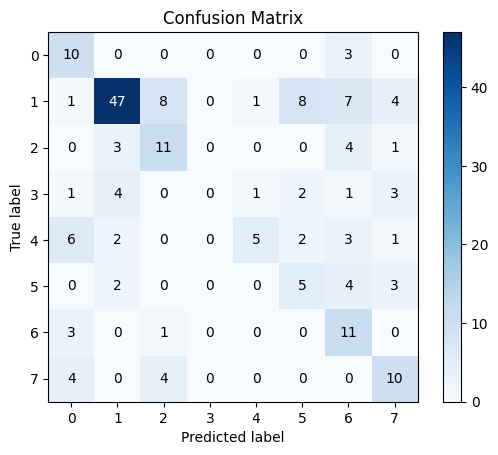

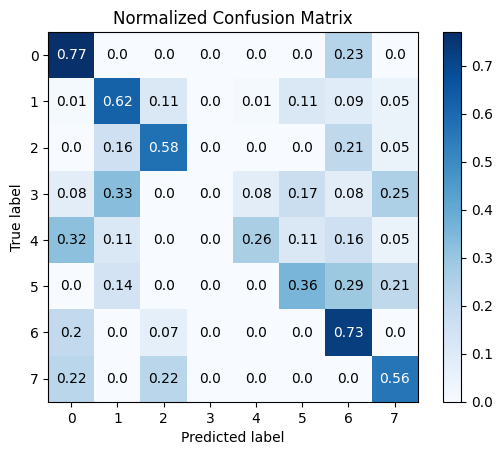

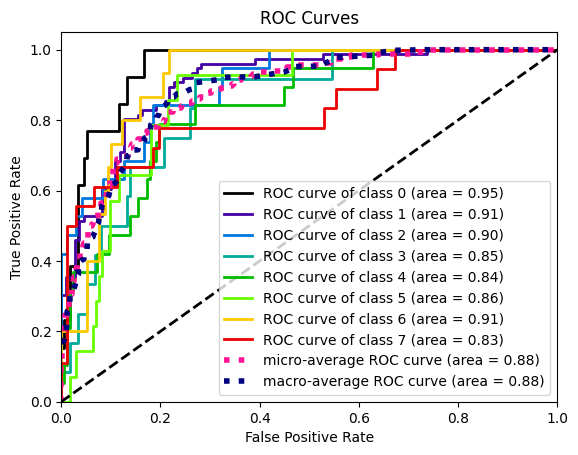

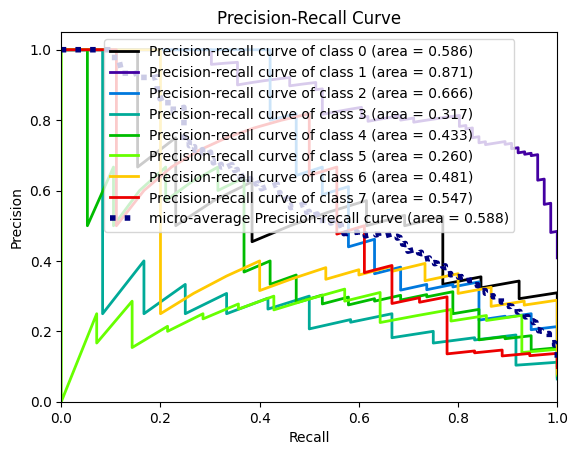

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)